# 3D Point Cloud Clustering with K-means and Python

Inside this notebook we will use K-Means clustering in order to seperate the <i>not ground</i> class into <i>vegetation </i> and <i>humanmade</i><br>
The main sourc of the clustering part is <a href=https://towardsdatascience.com/3d-point-cloud-clustering-tutorial-with-k-means-and-python-c870089f3af8>Florent Poux (2022): 3D Point Cloud Clusterin Tutorial with K-means and Python, Toward DataSciene</a>

<b>This Jupyter-Notebook is part of a master thesis with the topic<br>
<i>Analysis of deep learning methods for semantic segmentation of photogrammetric point clouds from aerial images</i><br>
&copy; Markus Hülsen, Matr.-Nr. 6026370<br>
Date: 15.08.2023</b>

## Setting up 3D Python Context
Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import laspy
import os
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.preprocessing import MinMaxScaler

## Import Data
Data is stored as `LAS`-file. We will use `laspy` to import und convert the data.<br>
First we create a function to import an `LAS`-File and convert them into a Pandas `DataFrame`.

In [2]:
def import_las_to_Dataframe(path):
    with laspy.open(path) as f:
        las = f.read()
    
    # read coordinates from las
    x = np.array(las.x)
    y = np.array(las.y)
    z = np.array(las.z)

    df = pd.DataFrame({'X':x,'Y':y,'Z':z},index=np.arange(len(x)))

    for i in range(3, len(las.point_format.dimensions)):
        dim = las.point_format.dimensions[i].name
        df[dim] = np.array(las[dim])
     
    return df

Express path where the data is stored, that we want to processed. <br>All `las`-Files inside the defined folder will be stored in a list.

In [3]:
# path where the data ist stored
data_path = '../../Daten/Datensatz_H3D/'
# sub-folder which includes different acquisition dates and types like 'DIM_2016', 'DIM_2019', 'DIM_2022', 'ALS2016', ...
data = 'DIM_2022/4 - Intersection_with_ALKIS'

# save files that are in laz-format
lst_files = []
for file in os.listdir(data_path + data):
    if file.endswith('.las'):
        lst_files.append(data_path + data + '/' + file)

        
lst_files = sorted(lst_files)
print('Found', len(lst_files), 'las-files:')
print(lst_files)

Found 12 las-files:
['../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/554000_5798000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/554000_5799000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/554000_5800000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/554000_5801000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/555000_5798000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/555000_5799000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/555000_5800000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/555000_5801000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/556000_5798000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/556000_5799000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/556000_5800000.las', '../../Daten/Datensatz_H3D/DIM_2022/4 - Inte

Use function above to read the point cloud and convert it to pandas DataFrame.

In [4]:
# define file we want to use
las_path = lst_files[0]
las_path

'../../Daten/Datensatz_H3D/DIM_2022/4 - Intersection_with_ALKIS/554000_5798000.las'

In [5]:
# import data
df = import_las_to_Dataframe(las_path)

df

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,...,scan_angle_rank,user_data,point_source_id,gps_time,red,green,blue,delta_z,z_to_dem,inside_road
0,554024.09,5798002.83,66.05,10442,0,7,0,0,2,0,...,-110,116,0,0.0,55040,54016,52224,0.188888,0.085888,0.0
1,554026.47,5798000.37,65.92,16696,0,2,0,0,2,0,...,126,200,0,0.0,42240,33280,27904,0.087113,-0.022089,0.0
2,554026.48,5798005.19,65.71,9527,0,2,0,0,2,0,...,123,123,0,0.0,9728,15616,19200,0.559579,0.456579,0.0
3,554026.66,5798005.76,65.80,9527,0,6,0,0,2,0,...,-116,113,0,0.0,6656,13056,15616,0.989986,0.886986,0.0
4,554049.63,5798046.24,64.24,10094,0,1,0,0,2,0,...,113,40,0,0.0,38144,36352,32000,-0.378887,-0.481887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,554999.26,5798835.98,84.83,7364,0,3,0,0,13,0,...,-110,138,0,0.0,16384,27392,20992,11.483861,11.281991,1.0
5631160,554989.94,5798860.83,83.46,7366,0,2,0,0,13,0,...,85,102,0,0.0,26880,38400,26112,9.923417,9.819417,1.0
5631161,554999.75,5798837.19,84.38,7366,0,2,0,0,13,0,...,-79,135,0,0.0,8960,15872,13312,10.909648,10.569705,1.0
5631162,554994.31,5798832.62,85.54,7361,0,3,0,0,13,0,...,104,97,0,0.0,14336,23296,18944,14.007186,13.903186,1.0


## Datapreparation
Some of the features are not necessary/redudant. We will remove them.

In [6]:
print('Attribute:')
for column in df:
    if len(pd.unique(df[column])) == 1:
        print(str(column) + (25 - len(str(column))) * ' '  + 'contains just a single value and will be returned!')
        df = df.drop(column, axis=1)
    else:
        print(str(column) +  (25 - len(str(column))) * ' '  + 'will be maintained')

df

Attribute:
X                        will be maintained
Y                        will be maintained
Z                        will be maintained
intensity                will be maintained
return_number            contains just a single value and will be returned!
number_of_returns        will be maintained
scan_direction_flag      contains just a single value and will be returned!
edge_of_flight_line      contains just a single value and will be returned!
classification           will be maintained
synthetic                contains just a single value and will be returned!
key_point                contains just a single value and will be returned!
withheld                 contains just a single value and will be returned!
scan_angle_rank          will be maintained
user_data                will be maintained
point_source_id          contains just a single value and will be returned!
gps_time                 contains just a single value and will be returned!
red                      will

,X,Y,Z,intensity,number_of_returns,classification,scan_angle_rank,user_data,red,green,blue,delta_z,z_to_dem,inside_road
0,554024.09,5798002.83,66.05,10442,7,2,-110,116,55040,54016,52224,0.188888,0.085888,0.0
1,554026.47,5798000.37,65.92,16696,2,2,126,200,42240,33280,27904,0.087113,-0.022089,0.0
2,554026.48,5798005.19,65.71,9527,2,2,123,123,9728,15616,19200,0.559579,0.456579,0.0
3,554026.66,5798005.76,65.80,9527,6,2,-116,113,6656,13056,15616,0.989986,0.886986,0.0
4,554049.63,5798046.24,64.24,10094,1,2,113,40,38144,36352,32000,-0.378887,-0.481887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,554999.26,5798835.98,84.83,7364,3,13,-110,138,16384,27392,20992,11.483861,11.281991,1.0
5631160,554989.94,5798860.83,83.46,7366,2,13,85,102,26880,38400,26112,9.923417,9.819417,1.0
5631161,554999.75,5798837.19,84.38,7366,2,13,-79,135,8960,15872,13312,10.909648,10.569705,1.0
5631162,554994.31,5798832.62,85.54,7361,3,13,104,97,14336,23296,18944,14.007186,13.903186,1.0


Drop attributes that are not necessary for segmentation.

In [7]:
# Delete all attirbute in this list
del_atts = ['return_number', 'point_source_id', 'delta_z']

df = df.drop(del_atts, axis=1, errors='ignore')

del del_atts

df

,X,Y,Z,intensity,number_of_returns,classification,scan_angle_rank,user_data,red,green,blue,z_to_dem,inside_road
0,554024.09,5798002.83,66.05,10442,7,2,-110,116,55040,54016,52224,0.085888,0.0
1,554026.47,5798000.37,65.92,16696,2,2,126,200,42240,33280,27904,-0.022089,0.0
2,554026.48,5798005.19,65.71,9527,2,2,123,123,9728,15616,19200,0.456579,0.0
3,554026.66,5798005.76,65.80,9527,6,2,-116,113,6656,13056,15616,0.886986,0.0
4,554049.63,5798046.24,64.24,10094,1,2,113,40,38144,36352,32000,-0.481887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,554999.26,5798835.98,84.83,7364,3,13,-110,138,16384,27392,20992,11.281991,1.0
5631160,554989.94,5798860.83,83.46,7366,2,13,85,102,26880,38400,26112,9.819417,1.0
5631161,554999.75,5798837.19,84.38,7366,2,13,-79,135,8960,15872,13312,10.569705,1.0
5631162,554994.31,5798832.62,85.54,7361,3,13,104,97,14336,23296,18944,13.903186,1.0


## Point Cloud Filtering

### Reduce area of the Pointcloud
For testing purposes we will reduce the size of the point cloud.<br>
To reduce the number of points within the pointcloud, we will create a Bounding-Box to select a smaller areas of the pointcloud.<br>
If we want to use the full extend of the point cloud, we will divide the bounding box by one.

In [8]:
# Bounding Box
bbox_x1 = df.X.min()
bbox_y1 = df.Y.min()
bbox_x2 = bbox_x1 + (df.X.max() - df.X.min()) / 1    # divide by one for the full extend
bbox_y2 = bbox_y1 + (df.Y.max() - df.Y.min()) / 1

# Select Point inside of Bounding Box
df_sub = df.loc[(df.X >= bbox_x1) & (df.Y >= bbox_y1) & (df.X <= bbox_x2) & (df.Y <= bbox_y2)]

print('Check Results')
print('X min:', df_sub.X.min(), 'X max:', df_sub.X.max())
print('Y min:', df_sub.Y.min(), 'Y max:', df_sub.Y.max())

# drop df to save memory
del df, bbox_x1, bbox_y1, bbox_x2, bbox_y2

df_sub

Check Results
X min: 554000.0 X max: 554999.96
Y min: 5798000.0 Y max: 5798999.74


,X,Y,Z,intensity,number_of_returns,classification,scan_angle_rank,user_data,red,green,blue,z_to_dem,inside_road
0,554024.09,5798002.83,66.05,10442,7,2,-110,116,55040,54016,52224,0.085888,0.0
1,554026.47,5798000.37,65.92,16696,2,2,126,200,42240,33280,27904,-0.022089,0.0
2,554026.48,5798005.19,65.71,9527,2,2,123,123,9728,15616,19200,0.456579,0.0
3,554026.66,5798005.76,65.80,9527,6,2,-116,113,6656,13056,15616,0.886986,0.0
4,554049.63,5798046.24,64.24,10094,1,2,113,40,38144,36352,32000,-0.481887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,554999.26,5798835.98,84.83,7364,3,13,-110,138,16384,27392,20992,11.281991,1.0
5631160,554989.94,5798860.83,83.46,7366,2,13,85,102,26880,38400,26112,9.819417,1.0
5631161,554999.75,5798837.19,84.38,7366,2,13,-79,135,8960,15872,13312,10.569705,1.0
5631162,554994.31,5798832.62,85.54,7361,3,13,104,97,14336,23296,18944,13.903186,1.0


### Just consider class `Not-Ground`
We just want to take a look on the point cloud that is classified as `Not-Ground` which is equal to `classification=13`

In [9]:
df_not_ground = df_sub.loc[df_sub.classification == 13.].drop('classification', axis=1)
df_not_ground

,X,Y,Z,intensity,number_of_returns,scan_angle_rank,user_data,red,green,blue,z_to_dem,inside_road
2693291,554851.97,5798849.28,78.64,18275,4,92,192,22016,30208,22016,5.088807,1.0
2693292,554857.73,5798849.28,77.85,16718,7,104,105,22272,28672,21248,7.448560,1.0
2693293,554851.66,5798849.36,79.83,17859,7,91,101,18688,27392,18688,6.231206,1.0
2693294,554851.24,5798849.65,75.98,18300,6,92,146,20736,27904,22016,2.462299,1.0
2693295,554852.96,5798849.56,77.55,18274,7,78,153,19456,27904,18944,4.569335,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,554999.26,5798835.98,84.83,7364,3,-110,138,16384,27392,20992,11.281991,1.0
5631160,554989.94,5798860.83,83.46,7366,2,85,102,26880,38400,26112,9.819417,1.0
5631161,554999.75,5798837.19,84.38,7366,2,-79,135,8960,15872,13312,10.569705,1.0
5631162,554994.31,5798832.62,85.54,7361,3,104,97,14336,23296,18944,13.903186,1.0


## Compute  Features
Compution of the geometric and radiometric feature of the point cloud.

In [11]:
# define path for temporary saving of the features
file = las_path.split('/')[-1].replace('.las', '')
path = las_path.replace(las_path.split('/')[-1], '').replace('4 - Intersection_with_ALKIS', '5 - KMeans/temp')

### Convert Colors

Change Color from 16bit to 8bit

In [12]:
r,g,b = df_not_ground.loc[:, 'red':'blue'].to_numpy().T
r, g ,b = (r/256).astype('uint8'), (g/256).astype('uint8'), (b/256).astype('uint8')
rgb = np.array([r,g,b]).T
print('RGB:\n', rgb)

RGB:
 [[ 86 118  86]
 [ 87 112  83]
 [ 73 107  73]
 ...
 [ 35  62  52]
 [ 56  91  74]
 [ 55  83  67]]


Normalize colors

In [13]:
rgb_norm = rgb/256

Convert the RGB values to HSV color space

#### RGB to HSV

In [14]:
import colorsys

In [15]:
hsv_norm = np.apply_along_axis(lambda x: colorsys.rgb_to_hsv(*x), -1, rgb_norm)
hsv_norm

array([[0.33333333, 0.27118644, 0.4609375 ],
       [0.31034483, 0.25892857, 0.4375    ],
       [0.33333333, 0.31775701, 0.41796875],
       ...,
       [0.4382716 , 0.43548387, 0.2421875 ],
       [0.41904762, 0.38461538, 0.35546875],
       [0.4047619 , 0.3373494 , 0.32421875]])

Save Hue, Saturation and Value to the feature DataFrame

In [16]:
# Colors in HSV-Colorspave
df_features = pd.DataFrame(hsv_norm, columns=['Hue', 'Saturation', 'Value'], index = df_not_ground.index)
df_features

,Hue,Saturation,Value
2693291,0.333333,0.271186,0.460938
2693292,0.310345,0.258929,0.437500
2693293,0.333333,0.317757,0.417969
2693294,0.363095,0.256881,0.425781
2693295,0.323810,0.321101,0.425781
...,...,...,...
5631159,0.403101,0.401869,0.417969
5631160,0.322917,0.320000,0.585938
5631161,0.438272,0.435484,0.242188
5631162,0.419048,0.384615,0.355469


Drop some variable to save RAM.

In [17]:
del r, g, b, rgb, rgb_norm, hsv_norm

### Define kNN with KDTree
Define the k-Nearest-Neighbors using the `KD-Tree` inside of the `sklearn` libary.<br>We will use `K = 100`

In [18]:
from sklearn.neighbors import KDTree
from Features.Shapefeatures import *
from Features.Geometric_Features import *

#### KD-Tree
Now let's builds a KD-Tree for faster compution and get the Nearest Neighbors.<br>
The number of neighbors `K` will be defined by `50`

In [19]:
# number of nearest neighbors
K = 100

kdt = KDTree(df_sub.loc[:,'X':'Z'], leaf_size=40, metric='euclidean')
indices = kdt.query(df_sub.loc[:,'X':'Z'], k=K, return_distance=False)

print('Indices:\n', indices)

Indices:
 [[      0     111     119 ...   26512      82   28780]
 [      1 2704464 2704176 ...      95 2770989 2704502]
 [      2      32      25 ...     105     107 2702899]
 ...
 [5631161 5630952 5630377 ... 5630396 5630671 5630518]
 [5631162 5630791 5631049 ... 5630911 5630367 5631054]
 [5631163 5630538 5630177 ... 5629948 5631035 5631020]]


Now create a 3D numpy arry with for each point with class 13, with the corrisponding nearest neighbors.<br>
The Pandas function `reset_index` will change the indexes listed from `0` to `n`, so we can use the indices as positions.

In [20]:
# Estimate position of points with class = 13
pos_class13 = df_sub.reset_index().loc[df_sub.reset_index().classification == 13].index.to_numpy()

# get labels of nerighboring points of class 13
labels = df_sub.classification.to_numpy()[indices][pos_class13]

### Calculate how often the class `building` in the neighborhood occurs

In [21]:
build_count = np.sum(labels == 6, axis=1)

print('Label "building" occurs', build_count, 'in the neighborhoods.')
print(len(build_count))

Label "building" occurs [0 0 0 ... 0 0 0] in the neighborhoods.
1964533


Save the results of the building counts to our Feature-DataFrame

In [22]:
# how often occurs the class building
df_features['count_building'] = build_count

Save Dataframe temporary.

In [23]:
df_features.to_csv(path + '/temp' + file + '.csv')
print('saved temporary file: ' + path + 'temp' + file + '.csv')

saved temporary file: ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/temp/temp554000_5798000.csv


### Build covariance matrix of neighbor points.

In [24]:
X = df_sub.loc[:,'X':'Z']

In [25]:
# convert Dataframe to Numpy array
xyz = X.to_numpy()

In [26]:
# get numpy array with nearest nighbors and select only with class = 13
xyz_minus_mean = xyz[indices][pos_class13] - np.mean(xyz[indices][pos_class13], axis=1)[:, np.newaxis, :]
print('Shape of reduced coordinates', xyz_minus_mean.shape)

Shape of reduced coordinates (1964533, 100, 3)


In [27]:
# build the covariance matrix of neighbor points
xyz_xyz = np.matmul(np.transpose(xyz_minus_mean, axes=(0, 2, 1)), xyz_minus_mean)
xyz_cov = xyz_xyz / (K-1)

print('Shape if Covariance-Matricies: ', xyz_cov.shape)
xyz_cov

Shape if Covariance-Matricies:  (1964533, 3, 3)


array([[[ 2.81492024e+00,  2.60442182e-01, -1.28723030e-01],
        [ 2.60442182e-01,  3.85503475e-01,  5.60510404e-01],
        [-1.28723030e-01,  5.60510404e-01,  3.38931187e+00]],

       [[ 2.51761870e+00, -5.65738414e-01, -6.18283646e-01],
        [-5.65738414e-01,  1.08728342e+00,  1.93286256e+00],
        [-6.18283646e-01,  1.93286256e+00,  6.20925062e+00]],

       [[ 1.94937652e+00,  4.19290404e-02, -1.12644949e-01],
        [ 4.19290404e-02,  6.48588636e-01,  8.64717677e-01],
        [-1.12644949e-01,  8.64717677e-01,  2.18215455e+00]],

       ...,

       [[ 1.53351696e+00, -1.91426515e-01, -2.11994838e-01],
        [-1.91426515e-01,  2.05129369e+00, -1.69377601e+00],
        [-2.11994838e-01, -1.69377601e+00,  2.06765151e+00]],

       [[ 1.06173466e+00, -1.63815040e-01,  6.49745687e-01],
        [-1.63815040e-01,  1.16924132e+00,  5.34622525e-02],
        [ 6.49745687e-01,  5.34622525e-02,  4.58604636e-01]],

       [[ 9.00479303e-01, -1.55090930e-04, -3.03505758e-01],
 

In [28]:
del xyz_xyz, xyz_minus_mean

### Calculate the geometric Features and eigenvectors / -values
Some of the features does not support vectorised calculation. <br>So we need to calculate some of the features inside of a for-loop, like eigenvalues and eigenvecotrs or the pointdensity.

To speed up this notebook we will use `multiprocessing`

In [29]:
import multiprocessing as mp
from datetime import datetime

Allocate DataFrame for the features and numpy arrays for eigenvectors and eigenvalues

In [30]:
# construct arrays to store eigenvalues and eigenvectors in
w = np.zeros((np.shape(xyz_cov)[0], 3))
v = np.zeros((np.shape(xyz_cov)[0], 3, 3))

Set the start time to check the processing time.<br>
Get the number of available CPU's to chuck our data.

In [31]:
start = datetime.now()

# Define the number of processes to use
num_processes = mp.cpu_count()

In [32]:
# Split the array into chunks
chunks = np.array_split(indices[pos_class13], num_processes)

Now we need a function which every processes can use.<br>
After we defined the function we will initalize a pool of processes and start the processes to calculate the local pointdensity for each point.

In [33]:
summe = 0
for chunk in chunks:
    summe += len(chunk)
    
print(len(pos_class13))
summe

1964533


1964533

In [34]:
def calc_feats(chunk):
    df = pd.DataFrame()
    for kNN in tqdm(chunk):
        point = X.iloc[kNN[0]]

        # PointCloud with Neighbors
        df_kNN = X.iloc[kNN, :]

        # CALCULATE GEOMETRIC FEATURES

        # local pointdensity
        df.loc[kNN[0], 'local pointdensity'] = local_pointdensity_kNN(point, df_kNN)
        
        # roughness
        df.loc[kNN[0], 'roughness'] = roughness(point, df_kNN)
    return df


# Create a pool of processes
pool = mp.Pool(num_processes)

# Process the chunks in parallel
results = pool.map(calc_feats, chunks)

# Close the pool of processes
pool.close()
pool.join()

In [35]:
# Concatenate the results
df_feat = pd.concat(results)
df_feat = df_feat.sort_index()
df_feat

,local pointdensity,roughness
2693291,0.432547,0.703173
2693292,0.349784,0.468599
2693293,0.539919,0.713651
2693294,0.713207,0.585209
2693295,0.470644,0.095084
...,...,...
5631159,0.511707,0.188456
5631160,1.737420,0.173722
5631161,0.258953,0.884695
5631162,1.691522,0.274876


Next up we want to calculate the roughness for every point.<br>
First we need the pointclouds as numpy array.

In [36]:
del df_sub, X

Next up are the eigenvectors and eigenvalues.

In [37]:
def calc_eigvec_and_eigval(xyz_chunk):
    # construct arrays to store eigenvalues and eigenvectors in
    w2 = np.zeros((np.shape(xyz_chunk)[0], 3))
    v2 = np.zeros((np.shape(xyz_chunk)[0], 3, 3))

    for i in range(xyz_chunk.shape[0]):
        w2[i], v2[i] = np.linalg.eig(xyz_cov[i])

    return w2, v2


# Crate a pool of processes
pool = mp.Pool(num_processes)

chunks = np.array_split(xyz_cov, num_processes)

# Process the chunks in parallel
results = pool.map(calc_eigvec_and_eigval, chunks)

# Close the pool of processes
pool.close()
pool.join()

# Concatenate the results
w = []
v = []
for cpu in range(num_processes):
    w.append(results[cpu][0])
    v.append(results[cpu][1])

w = np.concatenate(w)
v = np.concatenate(v)

### Calculate Features using vecotrisation

Normalisation of the eigenvectors and eigenvalues

In [38]:
# make sure eigenvalues are greater than 0.0    
eigenvalues = w
eigenvalues[eigenvalues <= np.finfo(np.float32).eps] = np.finfo(np.float32).eps

# normalize the eigenvectors
eigenvectors = v / np.linalg.norm(v, axis=-1)[:,:,np.newaxis]    


Calculation other features and add them into the Feature-DataFrame

In [40]:
# Standarddeviation of Z
df_features['std_z'] = xyz[indices][pos_class13].std(1)[:,2]

# Linearity
df_features['linearity'] = (eigenvalues[:,0] - eigenvalues[:,1]) / eigenvalues[:,0]

# Planarity
df_features['planarity'] = (eigenvalues[:,1] - eigenvalues[:,2]) / eigenvalues[:,0]

# Scattering
df_features['scattering'] = eigenvalues[:,2] / eigenvalues[:,0]

# Omnivariance
df_features['omnivariance'] = np.prod(eigenvalues, axis=1) ** (1 / 3)

# Ansiotropy
df_features['ansiotropy'] = (eigenvalues[:,0] - eigenvalues[:,2]) / eigenvalues[:,0]

# Eigenentropy
df_features['eigenentropy'] = -np.sum(eigenvalues * np.log(eigenvalues), axis=1)

# Sum of Eigenvalues
df_features['sum of eigvals'] = np.sum(w, axis=1)

# Change of Curvature
df_features['curvature change'] = eigenvalues[:,2] / np.sum(eigenvalues, axis=1)

df_features

,Hue,Saturation,Value,count_building,std_z,linearity,planarity,scattering,omnivariance,ansiotropy,eigenentropy,sum of eigvals,curvature change
2693291,0.333333,0.271186,0.460938,0,1.831780,-10.169637,-2.618226,13.787864,1.360767,-12.787864,-6.992655,6.589736,0.531171
2693292,0.310345,0.258929,0.437500,0,2.479346,0.650507,0.294663,0.054829,1.870121,0.945171,-15.401135,9.814153,0.039043
2693293,0.333333,0.317757,0.417969,0,1.469807,-0.329927,1.198396,0.131531,1.086089,0.868469,-3.390864,4.780120,0.053436
2693294,0.363095,0.256881,0.425781,0,1.539842,0.315037,0.571016,0.113947,1.237130,0.886053,-4.068542,5.207572,0.063342
2693295,0.323810,0.321101,0.425781,0,2.203302,-10.277171,-7.352250,18.629421,1.660899,-17.629421,-11.845517,8.634976,0.602765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,0.403101,0.401869,0.417969,0,1.014179,0.239105,0.420853,0.340042,1.735060,0.659958,-4.165377,5.720602,0.161853
5631160,0.322917,0.320000,0.585938,0,0.744005,-2.759296,-1.167037,4.926334,1.225969,-3.926334,-2.494549,4.488113,0.508623
5631161,0.438272,0.435484,0.242188,0,1.430725,-4.434209,-0.652039,6.086248,0.967749,-5.086248,-1.561126,3.774745,0.486104
5631162,0.419048,0.384615,0.355469,0,0.673809,0.265550,0.686164,0.048286,0.665257,0.951714,-1.791423,3.609796,0.027085


Add local pointdensity and roughness to feature DataFrame.

In [41]:
df_features.loc[df_feat.index, 'local_pointdensity'] = df_feat['local pointdensity']
df_features.loc[df_feat.index, 'roughness'] = df_feat['roughness']

df_features

,Hue,Saturation,Value,count_building,std_z,linearity,planarity,scattering,omnivariance,ansiotropy,eigenentropy,sum of eigvals,curvature change,local_pointdensity,roughness
2693291,0.333333,0.271186,0.460938,0,1.831780,-10.169637,-2.618226,13.787864,1.360767,-12.787864,-6.992655,6.589736,0.531171,0.432547,0.703173
2693292,0.310345,0.258929,0.437500,0,2.479346,0.650507,0.294663,0.054829,1.870121,0.945171,-15.401135,9.814153,0.039043,0.349784,0.468599
2693293,0.333333,0.317757,0.417969,0,1.469807,-0.329927,1.198396,0.131531,1.086089,0.868469,-3.390864,4.780120,0.053436,0.539919,0.713651
2693294,0.363095,0.256881,0.425781,0,1.539842,0.315037,0.571016,0.113947,1.237130,0.886053,-4.068542,5.207572,0.063342,0.713207,0.585209
2693295,0.323810,0.321101,0.425781,0,2.203302,-10.277171,-7.352250,18.629421,1.660899,-17.629421,-11.845517,8.634976,0.602765,0.470644,0.095084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,0.403101,0.401869,0.417969,0,1.014179,0.239105,0.420853,0.340042,1.735060,0.659958,-4.165377,5.720602,0.161853,0.511707,0.188456
5631160,0.322917,0.320000,0.585938,0,0.744005,-2.759296,-1.167037,4.926334,1.225969,-3.926334,-2.494549,4.488113,0.508623,1.737420,0.173722
5631161,0.438272,0.435484,0.242188,0,1.430725,-4.434209,-0.652039,6.086248,0.967749,-5.086248,-1.561126,3.774745,0.486104,0.258953,0.884695
5631162,0.419048,0.384615,0.355469,0,0.673809,0.265550,0.686164,0.048286,0.665257,0.951714,-1.791423,3.609796,0.027085,1.691522,0.274876


In [42]:
del df_feat, results, chunks, eigenvectors, eigenvalues

The calculation of the features is done!
Stop the time and see how much time we needed. 

In [43]:
end = datetime.now()
print('Needed', end - start, 'h for calculation\n')

Needed 2:00:52.660651 h for calculation



Of course we don't want to lose our data.<br>
Save them again as a csv.

In [44]:
df_features.to_csv(path + '/temp' + file + '.csv')
print('saved temporary file: ' + path + 'temp' + file + '.csv')

saved temporary file: ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/temp/temp554000_5798000.csv


### Import if already calculated
Import Features if they were already calculateted

In [45]:
is_calculate = False

if is_calculate:
    df_features = pd.read_csv(path + '/temp' + file + '.csv').set_index('Unnamed: 0')

df_features

,Hue,Saturation,Value,count_building,std_z,linearity,planarity,scattering,omnivariance,ansiotropy,eigenentropy,sum of eigvals,curvature change,local_pointdensity,roughness
2693291,0.333333,0.271186,0.460938,0,1.831780,-10.169637,-2.618226,13.787864,1.360767,-12.787864,-6.992655,6.589736,0.531171,0.432547,0.703173
2693292,0.310345,0.258929,0.437500,0,2.479346,0.650507,0.294663,0.054829,1.870121,0.945171,-15.401135,9.814153,0.039043,0.349784,0.468599
2693293,0.333333,0.317757,0.417969,0,1.469807,-0.329927,1.198396,0.131531,1.086089,0.868469,-3.390864,4.780120,0.053436,0.539919,0.713651
2693294,0.363095,0.256881,0.425781,0,1.539842,0.315037,0.571016,0.113947,1.237130,0.886053,-4.068542,5.207572,0.063342,0.713207,0.585209
2693295,0.323810,0.321101,0.425781,0,2.203302,-10.277171,-7.352250,18.629421,1.660899,-17.629421,-11.845517,8.634976,0.602765,0.470644,0.095084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,0.403101,0.401869,0.417969,0,1.014179,0.239105,0.420853,0.340042,1.735060,0.659958,-4.165377,5.720602,0.161853,0.511707,0.188456
5631160,0.322917,0.320000,0.585938,0,0.744005,-2.759296,-1.167037,4.926334,1.225969,-3.926334,-2.494549,4.488113,0.508623,1.737420,0.173722
5631161,0.438272,0.435484,0.242188,0,1.430725,-4.434209,-0.652039,6.086248,0.967749,-5.086248,-1.561126,3.774745,0.486104,0.258953,0.884695
5631162,0.419048,0.384615,0.355469,0,0.673809,0.265550,0.686164,0.048286,0.665257,0.951714,-1.791423,3.609796,0.027085,1.691522,0.274876


### Detect and eliminate outliners
Now that we got our Feature-Matrix, we sometimes need to eliminate some outliners.<br> For this reason will we calculate the mean und the standarddeviation of each column und use the `z-score` to find outliners.<br>
Every value which is outside of the intervall of `[mean - 3 * stddev; mean + 3 * stddev]` will be replaced with `NaN`.

In [46]:
# compute the z-score for each element in the DataFrame
z_scores = (df_features - df_features.mean()) / df_features.std()

# identify outliers using a threshold of 3 standard deviations
threshold = 4
outliers = np.abs(z_scores) > threshold

# replace outliers with NaN
df_features = df_features.where(~outliers, np.nan)
df_features[df_features.isna().any(axis=1)]

,Hue,Saturation,Value,count_building,std_z,linearity,planarity,scattering,omnivariance,ansiotropy,eigenentropy,sum of eigvals,curvature change,local_pointdensity,roughness
2693395,0.535714,0.100000,0.546875,0.0,0.915178,0.303785,-0.061935,0.758151,0.973189,0.241849,0.007173,2.955539,0.308899,0.117728,NaN
2693402,0.631579,0.147287,0.503906,0.0,NaN,0.865319,0.094708,0.039973,3.072495,0.960027,NaN,NaN,0.034030,0.069563,NaN
2693425,0.594203,0.179688,0.500000,0.0,0.916487,0.319768,-0.120486,0.800718,0.953559,0.199282,0.064915,2.896809,0.322747,0.106475,NaN
2693433,0.545455,0.074830,0.574219,0.0,NaN,0.857301,0.099181,0.043518,3.282856,0.956482,NaN,NaN,0.036686,0.075761,NaN
2693457,0.589744,0.189781,0.535156,0.0,0.914142,-0.259199,-0.366094,1.625292,1.041382,-0.625292,-0.254107,3.186170,0.418405,0.158720,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630880,0.300926,0.324324,0.433594,0.0,NaN,0.533280,0.396141,0.070579,1.037257,0.929421,-4.084948,4.974334,0.045911,0.061888,0.313294
5630892,0.322917,0.283186,0.441406,0.0,NaN,0.832223,-0.256819,0.424596,0.984383,0.575404,-1.695308,3.781285,0.266643,0.068463,0.407451
5630964,0.539474,0.447059,0.332031,0.0,1.587271,-12.871638,-9.138577,23.010215,0.811873,-22.010215,-3.318914,4.500250,0.607421,0.161606,NaN
5630978,0.430556,0.382979,0.367188,0.0,0.427557,-5.606411,-4.131092,10.737504,NaN,-9.737504,NaN,NaN,0.585344,0.974081,0.436340


### Visualize the computed features
To get a better understanding if the calculated features contain valuable information we will visualize them in some <b>histograms</b> and <b>correlation plots</b>.

In [54]:
def features_to_hist(df, cols):
    # number of attributes
    num_atts = len(df.columns)
    
    # number of rows in plot depends on number of attributes and number of columns
    if num_atts%cols == 0:
        rows = num_atts//cols
    else:
        rows = num_atts//cols + 1
    
    fig, axs = plt.subplots(rows, cols, figsize=(10*cols, 6*rows))

    # counter, to estimate the position in plot
    hist_col = 0
    hist_row = 0

    for column in df:
        data = df.loc[:,column]
    
        axs[hist_row][hist_col].hist(data.to_numpy(), bins=35)
        axs[hist_row][hist_col].set_title(column)
    
        hist_col += 1
    
        if hist_col >= cols:
            hist_col = 0
            hist_row += 1
    plt.savefig('histo.png')

            
def visualize_correlation(df_corr, fig_size):
    # takes the Correlation-DataFrame as Input
    
    corr_array = df_corr.to_numpy()

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    im = ax.imshow(corr_array)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(df_corr.columns)))
    ax.set_xticklabels(df_corr.columns)
    ax.set_yticks(np.arange(len(df_corr.columns)))
    ax.set_yticklabels(df_corr.columns)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(df_corr.columns)):
        for j in range(len(df_corr.columns)):
            text = ax.text(j, i, round(corr_array[i, j], 2),
                           ha="center", va="center", color="w")
    
    ax.set_title("Correlation between attributes")
    fig.tight_layout()
    plt.savefig('correlation.png')
    plt.show()

#### Histograms of the Features

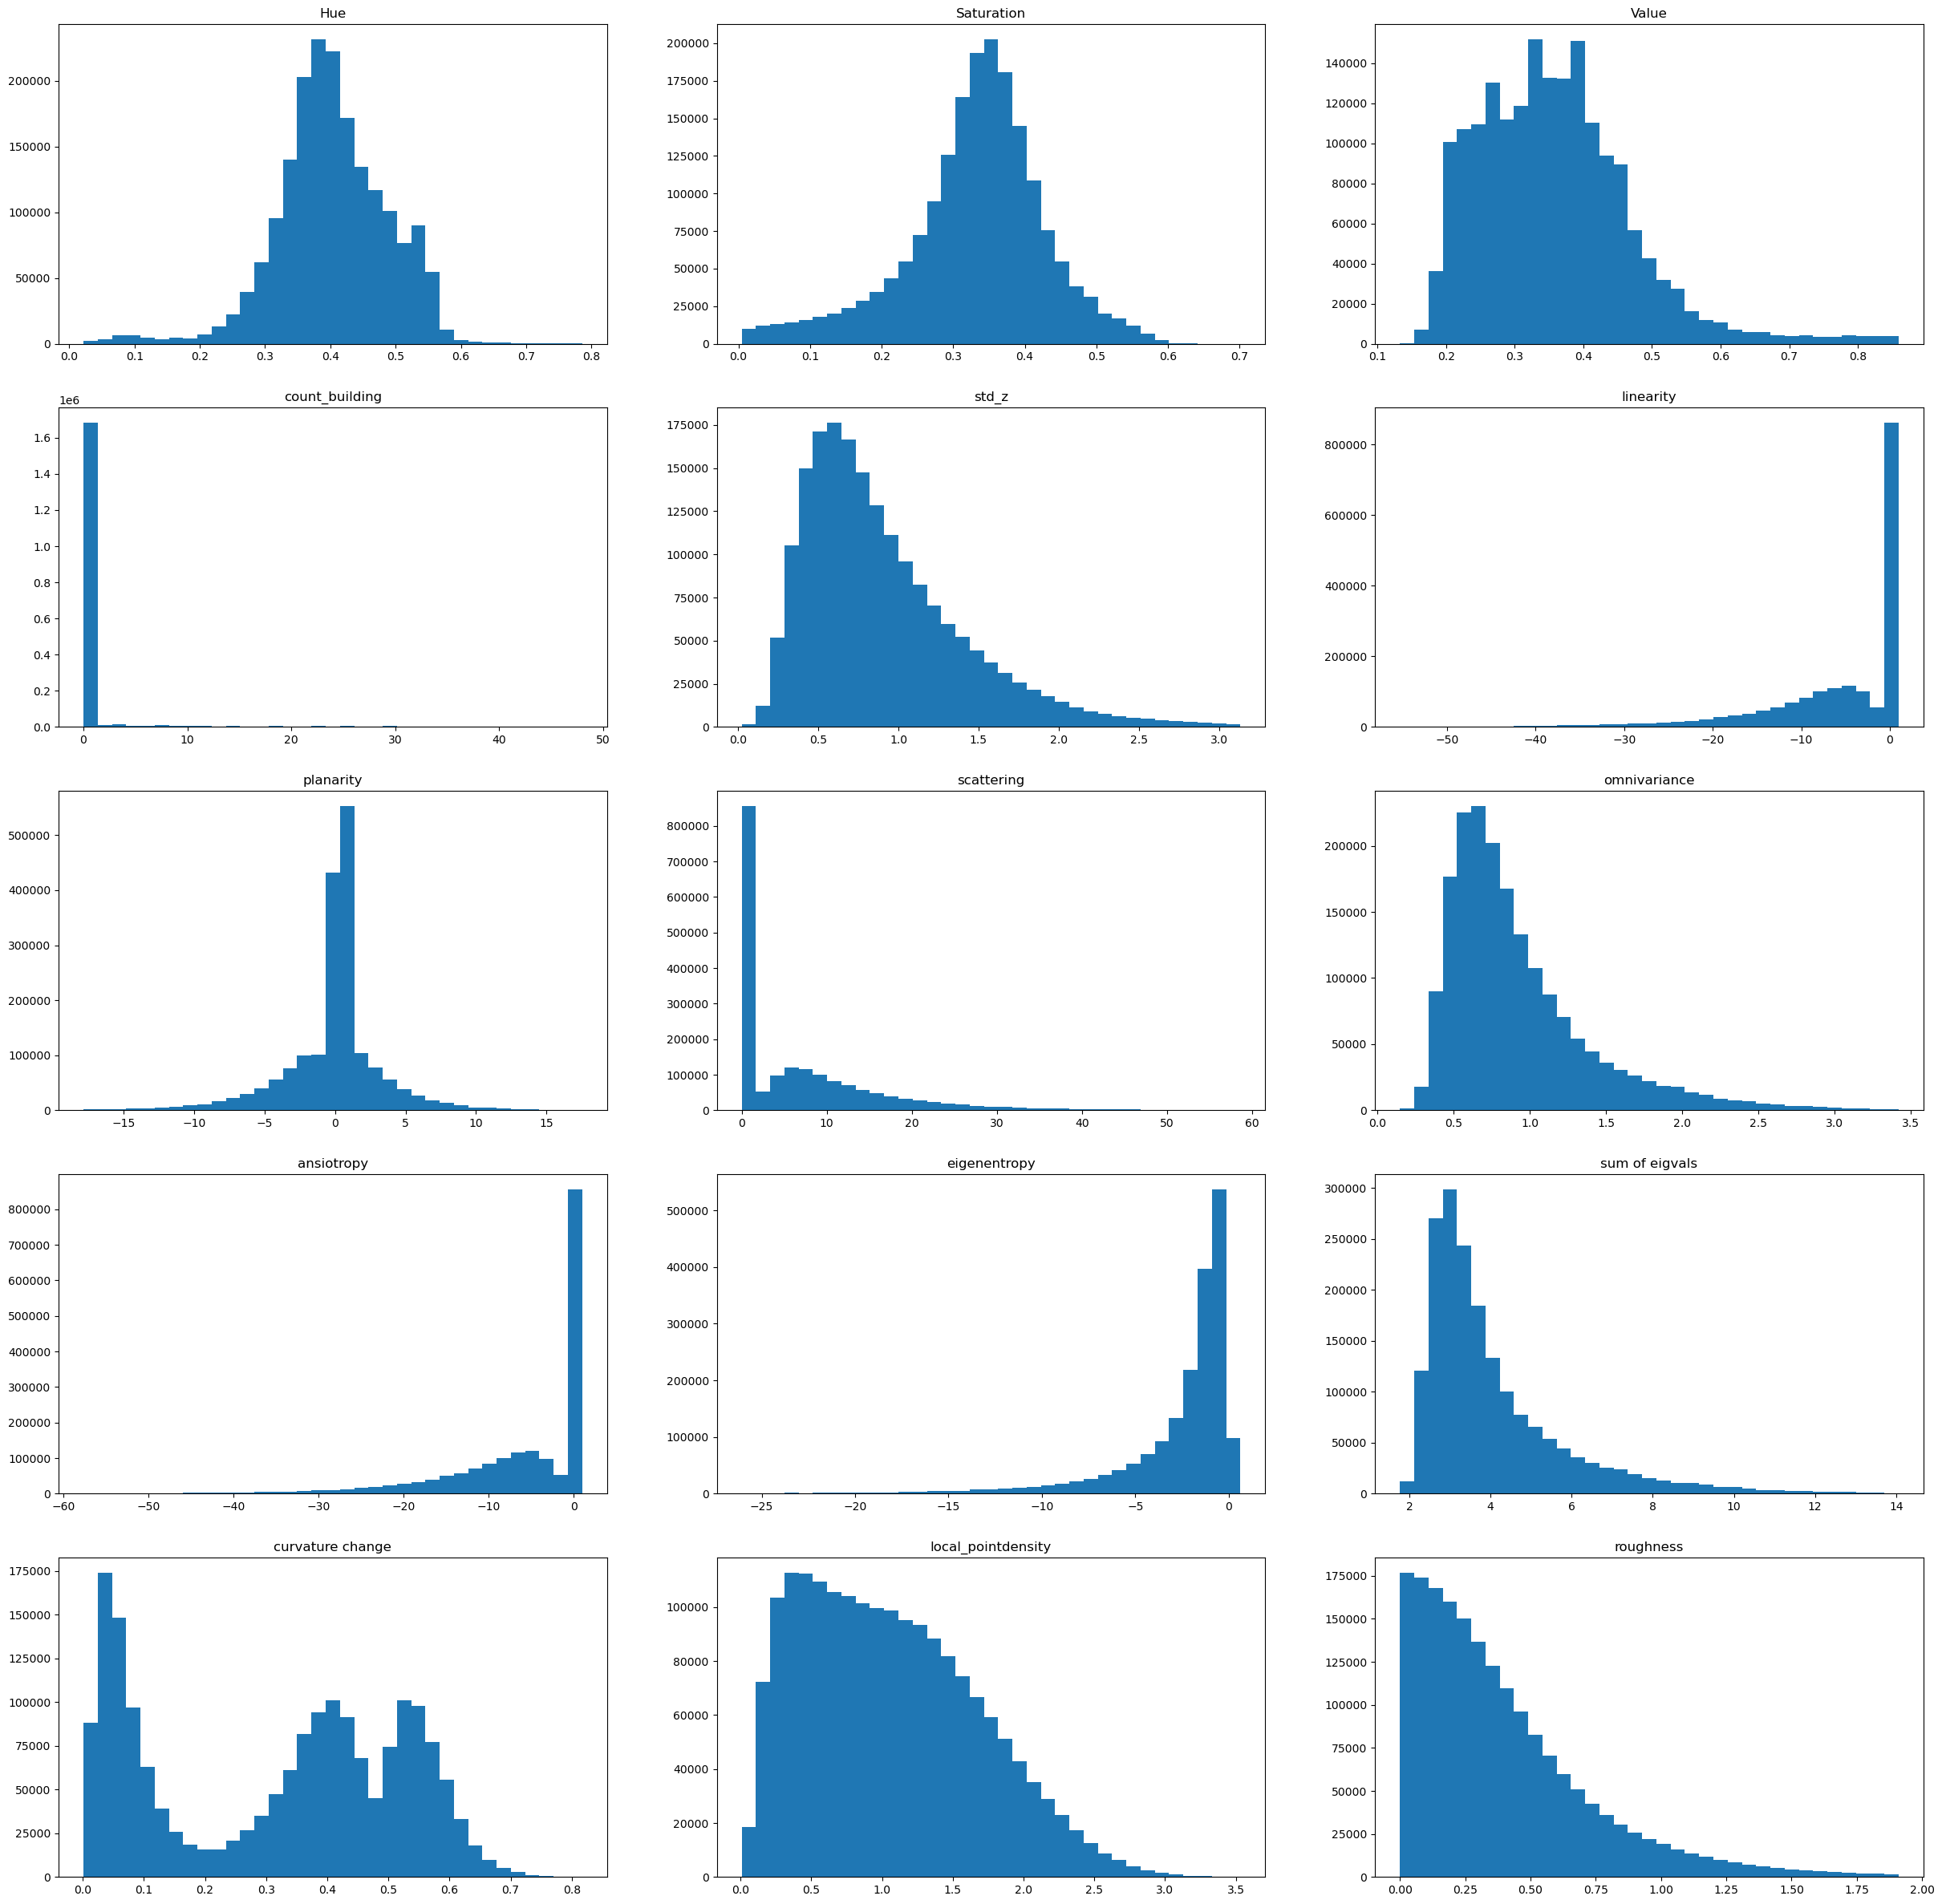

In [55]:
features_to_hist(df_features.dropna(), cols=3)

#### Correlation Plot

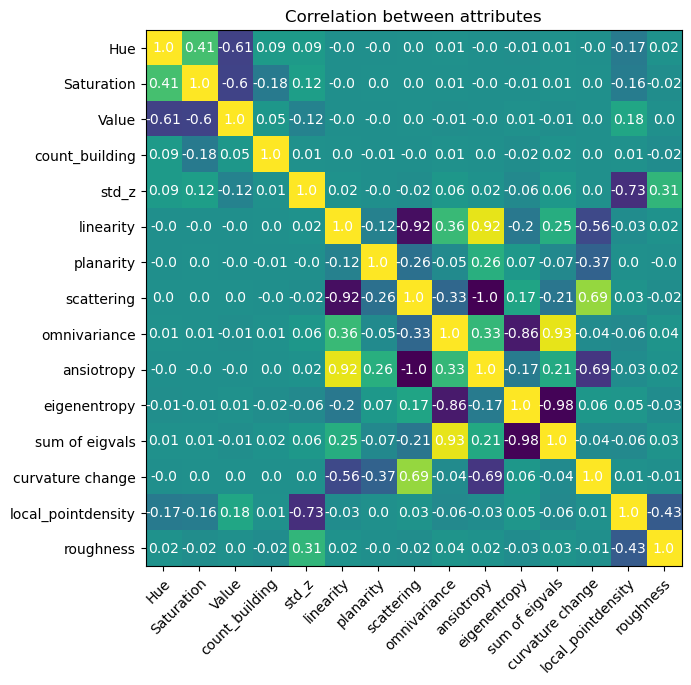

In [53]:
visualize_correlation(df_features.dropna().corr(), 7)

### Drop redundant and irrelevant features
Now we need to decide which features we want to use for our KMeans segmentation. <br>
Features with a high correlation should be eliminated.

In [56]:
drop = ['scattering', 'ansiotropy', 'omnivariance', 'sum of eigvals']

df_features = df_features.drop(drop, axis=1, errors='ignore')

df_features

,Hue,Saturation,Value,count_building,std_z,linearity,planarity,eigenentropy,curvature change,local_pointdensity,roughness
2693291,0.333333,0.271186,0.460938,0.0,1.831780,-10.169637,-2.618226,-6.992655,0.531171,0.432547,0.703173
2693292,0.310345,0.258929,0.437500,0.0,2.479346,0.650507,0.294663,-15.401135,0.039043,0.349784,0.468599
2693293,0.333333,0.317757,0.417969,0.0,1.469807,-0.329927,1.198396,-3.390864,0.053436,0.539919,0.713651
2693294,0.363095,0.256881,0.425781,0.0,1.539842,0.315037,0.571016,-4.068542,0.063342,0.713207,0.585209
2693295,0.323810,0.321101,0.425781,0.0,2.203302,-10.277171,-7.352250,-11.845517,0.602765,0.470644,0.095084
...,...,...,...,...,...,...,...,...,...,...,...
5631159,0.403101,0.401869,0.417969,0.0,1.014179,0.239105,0.420853,-4.165377,0.161853,0.511707,0.188456
5631160,0.322917,0.320000,0.585938,0.0,0.744005,-2.759296,-1.167037,-2.494549,0.508623,1.737420,0.173722
5631161,0.438272,0.435484,0.242188,0.0,1.430725,-4.434209,-0.652039,-1.561126,0.486104,0.258953,0.884695
5631162,0.419048,0.384615,0.355469,0.0,0.673809,0.265550,0.686164,-1.791423,0.027085,1.691522,0.274876


### Combine all Features
Now lets combine the calculated and observed features to new DataFrame.

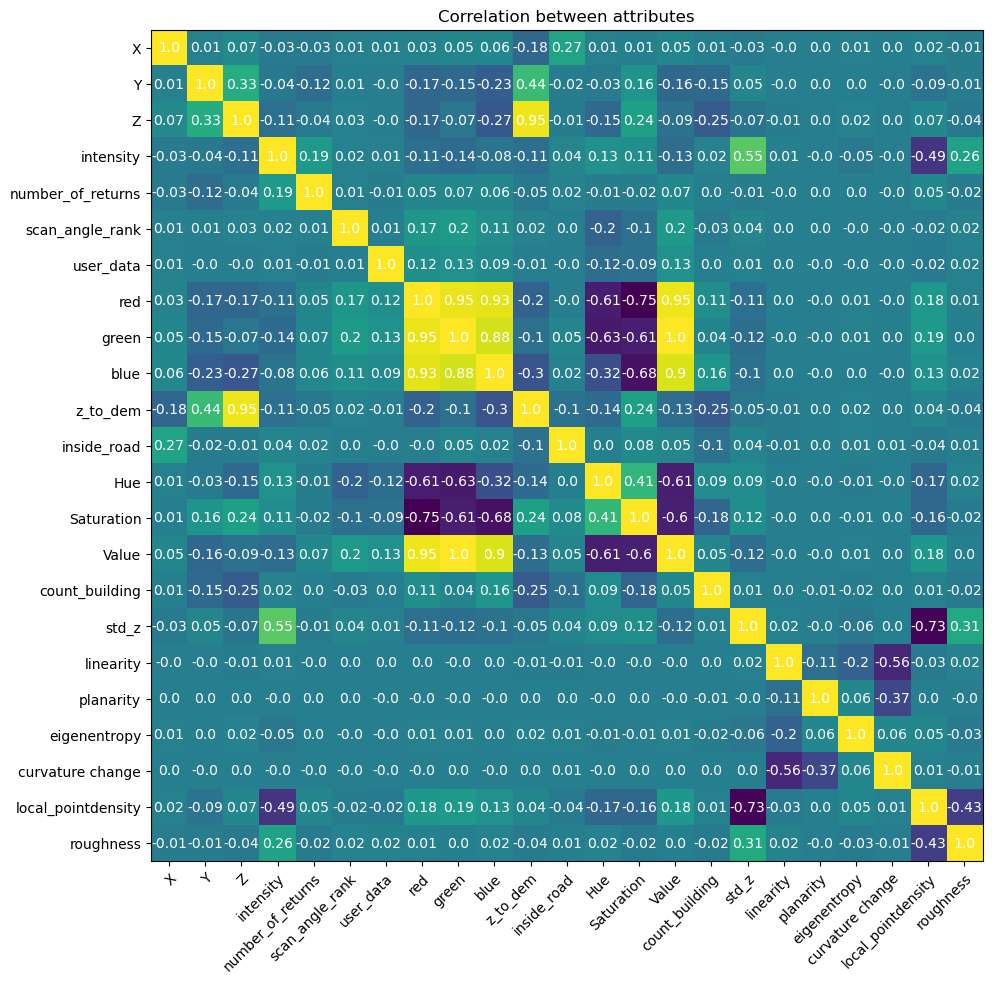

,X,Y,Z,intensity,number_of_returns,scan_angle_rank,user_data,red,green,blue,...,Saturation,Value,count_building,std_z,linearity,planarity,eigenentropy,curvature change,local_pointdensity,roughness
2693291,554851.97,5798849.28,78.64,18275,4,92,192,22016,30208,22016,...,0.271186,0.460938,0.0,1.831780,-10.169637,-2.618226,-6.992655,0.531171,0.432547,0.703173
2693292,554857.73,5798849.28,77.85,16718,7,104,105,22272,28672,21248,...,0.258929,0.437500,0.0,2.479346,0.650507,0.294663,-15.401135,0.039043,0.349784,0.468599
2693293,554851.66,5798849.36,79.83,17859,7,91,101,18688,27392,18688,...,0.317757,0.417969,0.0,1.469807,-0.329927,1.198396,-3.390864,0.053436,0.539919,0.713651
2693294,554851.24,5798849.65,75.98,18300,6,92,146,20736,27904,22016,...,0.256881,0.425781,0.0,1.539842,0.315037,0.571016,-4.068542,0.063342,0.713207,0.585209
2693295,554852.96,5798849.56,77.55,18274,7,78,153,19456,27904,18944,...,0.321101,0.425781,0.0,2.203302,-10.277171,-7.352250,-11.845517,0.602765,0.470644,0.095084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,554999.26,5798835.98,84.83,7364,3,-110,138,16384,27392,20992,...,0.401869,0.417969,0.0,1.014179,0.239105,0.420853,-4.165377,0.161853,0.511707,0.188456
5631160,554989.94,5798860.83,83.46,7366,2,85,102,26880,38400,26112,...,0.320000,0.585938,0.0,0.744005,-2.759296,-1.167037,-2.494549,0.508623,1.737420,0.173722
5631161,554999.75,5798837.19,84.38,7366,2,-79,135,8960,15872,13312,...,0.435484,0.242188,0.0,1.430725,-4.434209,-0.652039,-1.561126,0.486104,0.258953,0.884695
5631162,554994.31,5798832.62,85.54,7361,3,104,97,14336,23296,18944,...,0.384615,0.355469,0.0,0.673809,0.265550,0.686164,-1.791423,0.027085,1.691522,0.274876


In [57]:
df_features = pd.merge(df_not_ground, df_features, left_index=True, right_index=True)
visualize_correlation(df_features.dropna().corr(), 10)
df_features

Generate a Sub-Feature-DataFrame with the features we want to use for K-Means

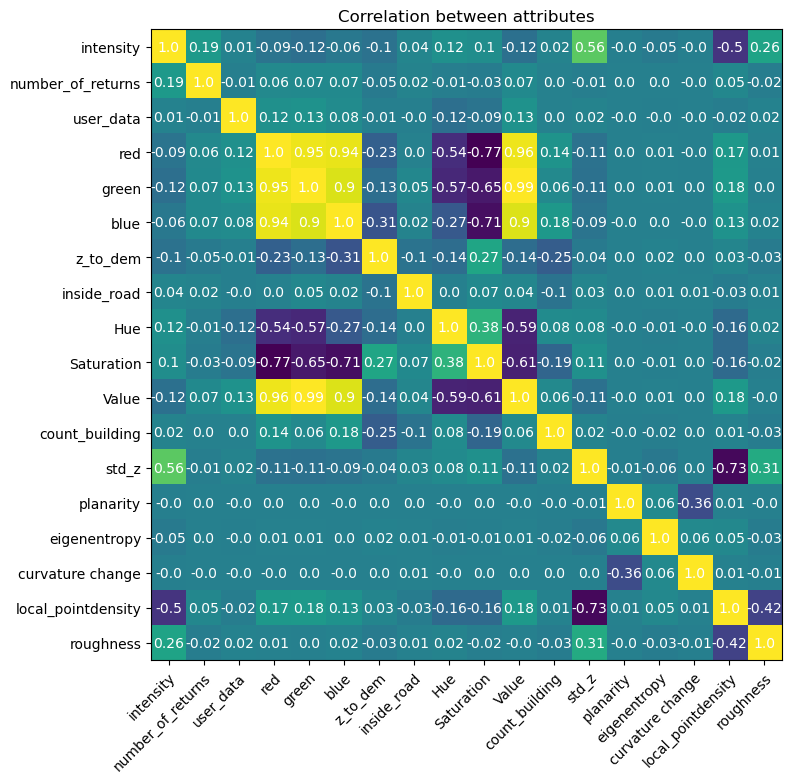

,intensity,number_of_returns,user_data,red,green,blue,z_to_dem,inside_road,Hue,Saturation,Value,count_building,std_z,planarity,eigenentropy,curvature change,local_pointdensity,roughness
2693291,18275,4,192,22016,30208,22016,5.088807,1.0,0.333333,0.271186,0.460938,0.0,1.831780,-2.618226,-6.992655,0.531171,0.432547,0.703173
2693292,16718,7,105,22272,28672,21248,7.448560,1.0,0.310345,0.258929,0.437500,0.0,2.479346,0.294663,-15.401135,0.039043,0.349784,0.468599
2693293,17859,7,101,18688,27392,18688,6.231206,1.0,0.333333,0.317757,0.417969,0.0,1.469807,1.198396,-3.390864,0.053436,0.539919,0.713651
2693294,18300,6,146,20736,27904,22016,2.462299,1.0,0.363095,0.256881,0.425781,0.0,1.539842,0.571016,-4.068542,0.063342,0.713207,0.585209
2693295,18274,7,153,19456,27904,18944,4.569335,1.0,0.323810,0.321101,0.425781,0.0,2.203302,-7.352250,-11.845517,0.602765,0.470644,0.095084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631159,7364,3,138,16384,27392,20992,11.281991,1.0,0.403101,0.401869,0.417969,0.0,1.014179,0.420853,-4.165377,0.161853,0.511707,0.188456
5631160,7366,2,102,26880,38400,26112,9.819417,1.0,0.322917,0.320000,0.585938,0.0,0.744005,-1.167037,-2.494549,0.508623,1.737420,0.173722
5631161,7366,2,135,8960,15872,13312,10.569705,1.0,0.438272,0.435484,0.242188,0.0,1.430725,-0.652039,-1.561126,0.486104,0.258953,0.884695
5631162,7361,3,97,14336,23296,18944,13.903186,1.0,0.419048,0.384615,0.355469,0.0,0.673809,0.686164,-1.791423,0.027085,1.691522,0.274876


In [58]:
drop_features = ['X', 'Y', 'Z', 'linearity', 'scan_angle_rank']
sub_df_features = df_features.drop(drop_features, axis=1, errors='ignore')
visualize_correlation(sub_df_features.corr(), 8)
sub_df_features

Decide which features we want to use for KMeans.

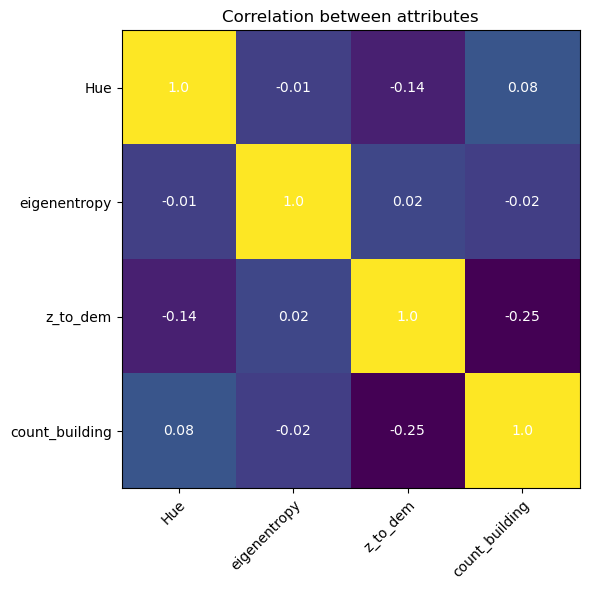

,Hue,eigenentropy,z_to_dem,count_building
2693291,0.333333,-6.992655,5.088807,0.0
2693292,0.310345,-15.401135,7.448560,0.0
2693293,0.333333,-3.390864,6.231206,0.0
2693294,0.363095,-4.068542,2.462299,0.0
2693295,0.323810,-11.845517,4.569335,0.0
...,...,...,...,...
5631159,0.403101,-4.165377,11.281991,0.0
5631160,0.322917,-2.494549,9.819417,0.0
5631161,0.438272,-1.561126,10.569705,0.0
5631162,0.419048,-1.791423,13.903186,0.0


In [59]:
features = ['Hue', 'eigenentropy', 'z_to_dem', 'count_building']
sub_df = sub_df_features.loc[:,features]
visualize_correlation(sub_df.corr(), 6)
sub_df

### Clean Data
Now elimate the outliners which were replaced with a `NaN`-value.

In [60]:
# indices we want to drop
del_ind = sub_df[sub_df.isna().any(axis=1)].index
print(len(del_ind), 'Datasets will be deleted')

66490 Datasets will be deleted


In [61]:
# Drop the rows in our point DataFrame
df_features_clean = df_features.drop(del_ind, axis=0, errors='ignore')
print('Shape of DataFrame with points: ', df_features_clean.shape)

# Drop the rows in our sub-feature DataFrame
sub_df = sub_df.drop(del_ind, axis=0)
print('Shape of DataFrame with features: ', sub_df.shape)

Shape of DataFrame with points:  (1898043, 23)
Shape of DataFrame with features:  (1898043, 4)


## Implementation of K-Means

For the implementation of K-Means we will use the `Scikit-learn` Library.

For an easier clustering we do two different clustering. <br>
One for the points within the ALKIS-Classes `AX_Strassenverkehr`, `AX_Weg` und `AX_Platz`

In [62]:
# Get indices of the points inside of the road
ind_X_inside = df_features_clean.loc[df_features_clean.inside_road == 1].index

# X inside of road
X_inside = sub_df.loc[ind_X_inside, :].to_numpy()

len(X_inside)

398632

In [63]:
# Get indices of the points inside of the road
ind_X_outside = df_features_clean.loc[df_features_clean.inside_road == 0].index

# X outside of road
X_outside = sub_df.loc[ind_X_outside,:].to_numpy()

X_outside

array([[ 0.32432432, -1.05642966, 12.17995453,  0.        ],
       [ 0.36036036, -2.76706572, 12.56574059,  0.        ],
       [ 0.23497268, -1.09214779, 18.2808075 ,  0.        ],
       ...,
       [ 0.3625    , -1.26757942, 15.01969051,  0.        ],
       [ 0.3968254 , -2.51117043,  8.72545815,  0.        ],
       [ 0.39655172, -3.98777862, 20.54909897,  0.        ]])

### Scaling with MinMaxScaler
Scale the calculated values using the MinMaxScaler of the `Sci-Kit learn` library.<br>
Every Feature will be scaled in an intervall `[0:1]`

In [64]:
X_inside_scaled = MinMaxScaler().fit_transform(X_inside)
X_outside_scaled = MinMaxScaler().fit_transform(X_outside)

print('Shape of Feature Matrix outside road: ', X_outside_scaled.shape)
X_outside_scaled

Shape of Feature Matrix outside road:  (1499411, 4)


array([[0.3960668 , 0.93687408, 0.3967589 , 0.        ],
       [0.44323592, 0.87281653, 0.40756407, 0.        ],
       [0.27911058, 0.93553655, 0.56763284, 0.        ],
       ...,
       [0.44603659, 0.92896723, 0.47629481, 0.        ],
       [0.49096658, 0.88239895, 0.30000465, 0.        ],
       [0.49060835, 0.82710496, 0.63116361, 0.        ]])

In [65]:
print('Shape of Feature Matrix inside road: ', X_inside_scaled.shape)
X_inside_scaled

Shape of Feature Matrix inside road:  (398632, 4)


array([[0.40785908, 0.71458249, 0.20736033, 0.        ],
       [0.37776843, 0.39971331, 0.28412653, 0.        ],
       [0.40785908, 0.84945738, 0.24452425, 0.        ],
       ...,
       [0.5452173 , 0.91797489, 0.38566196, 0.        ],
       [0.5200542 , 0.90935107, 0.49410496, 0.        ],
       [0.50135501, 0.92696293, 0.53208537, 0.        ]])

Choosing the right number of `K` may not be so obvious. We can use the <b>Elbow method</b> if we want some heuristic help.<br>
We will loop `K` over a range of `[1:20]`, execute our K-Means clustering with the `K` and compute a WCSS (Within-Cluster Sum of Square) value that we will store in a list

In [66]:
#Skip elbow method?
skip = False
wcss = []

if not skip:
    for i in tqdm(range(1, 20)):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X_outside_scaled)
        wcss.append(kmeans.inertia_)

  0%|          | 0/19 [00:00<?, ?it/s]

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/markus/anacond

Then, once out `wcss` list is complete, we can plot the graph with the calculated `wcss` value corresponding to the `K` value.

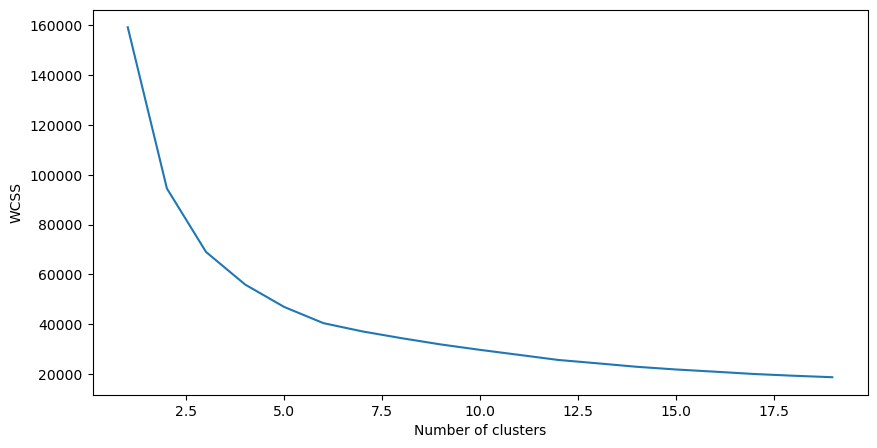

<Figure size 640x480 with 0 Axes>

In [73]:
if not skip:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.plot(range(1, 20), wcss)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS') 

    plt.show();
    plt.savefig('Elbow.png');

As we can see in the plot above, 5 seems to be a suitable parameter<br>
Lets fit our Feature Vector again with `K=5` und save the labels.

### K-Means for outside the road

In [62]:
K = 8
kmeans_outside = KMeans(n_clusters = K, init = 'k-means++', random_state = 42)

In [63]:
kmeans_outside.fit(X_outside_scaled)

labels_outside = kmeans_outside.labels_
labels_outside;

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [64]:
len(labels_outside)

1280472

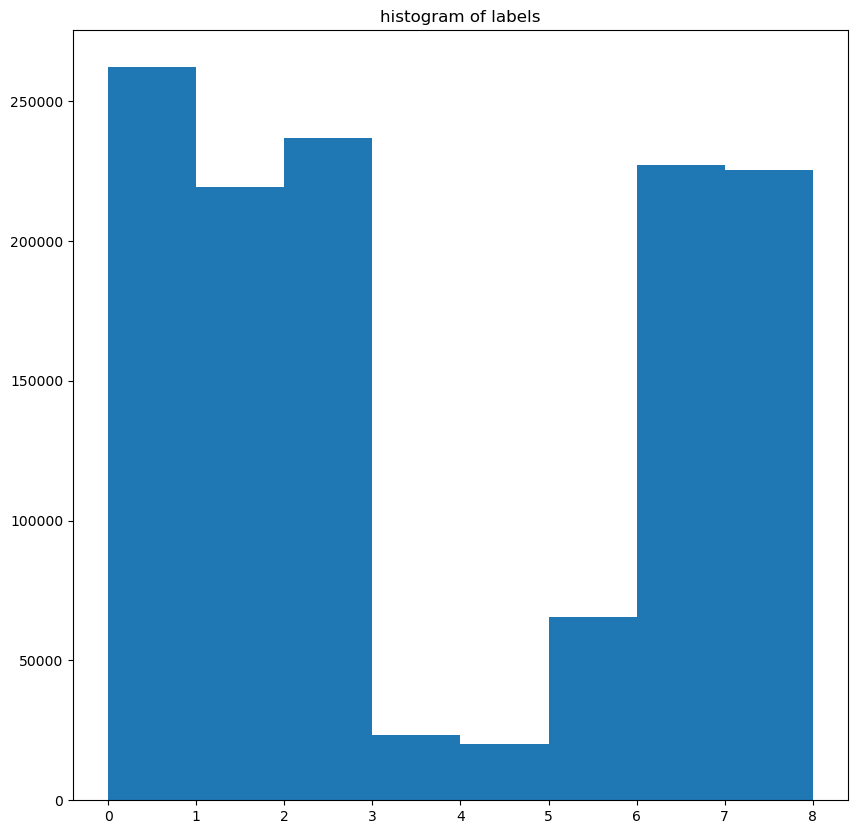

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.hist(labels_outside, bins = np.arange(0, K+1))
ax.set_title("histogram of labels")
ax.set_xticks(np.arange(0, K+1))
plt.show()

### K-Means for inside the road

In [66]:
K = 8
kmeans_inside = KMeans(n_clusters = K, init = 'k-means++', random_state = 42)

In [67]:
len(X_inside_scaled)

145641

In [68]:
kmeans_inside.fit(X_inside_scaled)

labels_inside = kmeans_inside.labels_ + K
labels_inside

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([13, 13, 14, ..., 14, 14, 14], dtype=int32)

In [69]:
len(labels_inside)

145641

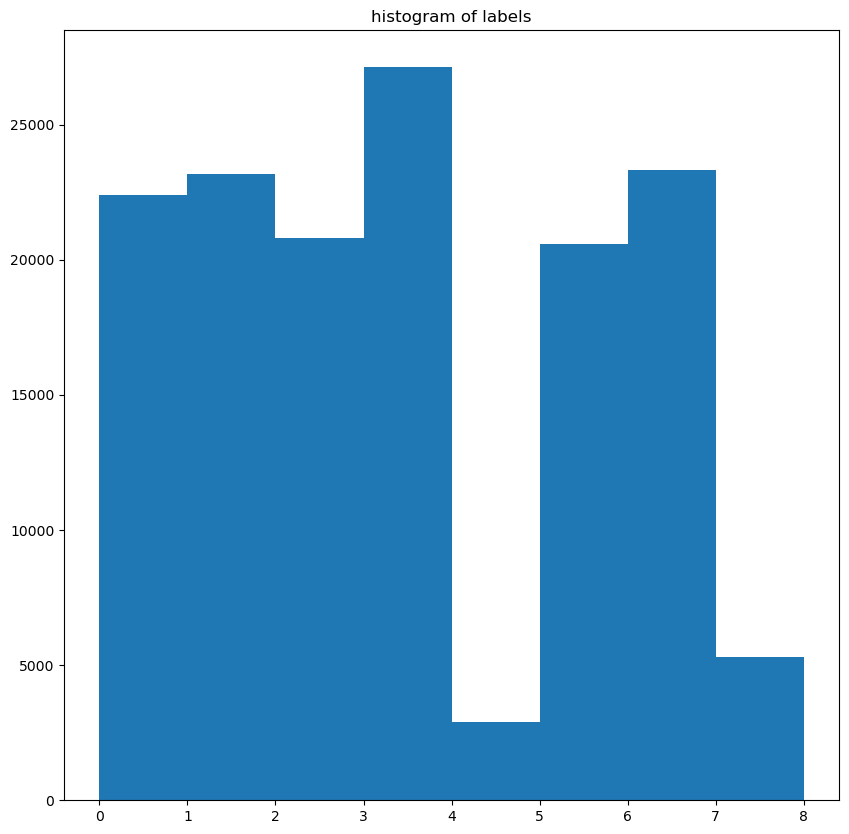

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.hist(labels_inside-K, bins = np.arange(0, K+1))
ax.set_title("histogram of labels")
ax.set_xticks(np.arange(0, K+1))
plt.show()

## Save Results

Merge label results with the corresponding indices.

### Add Results to DataFrame

In [71]:
df_features.loc[ind_X_inside, 'label'] = labels_inside
df_features.loc[ind_X_outside, 'label'] = labels_outside

df_features

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Value,count_building,std_z,linearity,planarity,eigenentropy,curvature change,local_pointdensity,roughness,label
2014265,554630.78,5799247.01,66.32,16930,6,0,75,10752,16640,17152,...,0.261719,0.0,2.332456,0.716251,-0.079184,-16.871500,0.220403,0.172814,0.759309,13.0
2014266,554631.00,5799254.93,67.07,17799,5,0,177,9216,16128,17408,...,0.265625,0.0,1.428262,-0.903620,-0.998008,-3.880663,0.499828,0.396333,0.576001,13.0
2014267,554631.17,5799253.86,68.53,18296,3,0,204,9216,15872,13312,...,0.242188,0.0,2.839431,-2.188969,-4.916587,-23.795299,0.659282,0.231926,0.090205,14.0
2014268,554630.31,5799245.95,67.03,16223,7,0,116,7168,12032,11264,...,0.183594,0.0,1.810200,0.703935,-0.083093,-11.943771,0.226333,0.189320,1.665934,13.0
2014269,554630.55,5799252.05,67.53,17570,2,0,211,11008,16896,14080,...,0.257812,0.0,2.605570,0.865600,-0.255277,-20.263545,0.255680,0.265720,1.187753,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096488,554858.09,5799989.33,88.15,7627,1,0,68,10752,16896,11264,...,0.257812,0.0,0.935076,0.611049,0.252380,-21.760246,0.089524,1.334330,0.397809,0.0
5096489,554856.45,5799992.21,87.60,7669,2,0,152,20736,32512,28160,...,0.496094,0.0,0.499162,0.799764,-0.289243,-8.691372,0.289681,1.515980,0.004916,0.0
5096490,554846.99,5799990.54,87.27,7630,3,0,163,16640,26112,20736,...,0.398438,0.0,0.626070,0.628917,-0.198883,-4.913447,0.293638,1.142031,0.041255,0.0
5096491,554803.23,5799997.52,85.64,7678,5,0,122,15360,24576,19200,...,0.375000,0.0,0.630582,-10.825417,3.052714,-0.645937,0.406179,0.914952,0.641851,0.0


### Write new LAS-File
Following function will save a DataFrame to the input path.

In [72]:
def save_df_to_las(df, path):
    
    header = laspy.LasHeader(point_format=3, version="1.2")
    
    atts = []
    for dim in header.point_format.dimensions:
        atts.append(dim.name)
    
    for dim in df.columns:
        if dim not in atts:
            header.add_extra_dim(laspy.ExtraBytesParams(name=dim, type=np.float32))
    
    las_new = laspy.LasData(header)

    las_new.x = df.X.to_numpy()
    las_new.y = df.Y.to_numpy()
    las_new.z = df.Z.to_numpy()
    
    for col in df.loc[:,'intensity':].columns:
        las_new[col] = df[col].to_numpy()
    
    las_new.write(path)
    print('LAS file has been exported to ', path)

#### Export classfied pointcloud
Define export Path and use save function

In [73]:
las_file = 'classified' + las_path.split('/')[-1]
path = las_path.replace(las_path.split('/')[-1], '').replace('4 - Intersection_with_ALKIS', '5 - KMeans/classified')
path + las_file

'../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified554000_5799000.las'

#### Export K-Means resutls
Define path, where the data will be stored

In [74]:
file.replace('.las','')

'554000_5799000'

In [75]:
path = path.replace('classified', file.replace('.las',''))
path

'../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/'

Check if folder already exists. <br> If not, create a new one.

In [76]:
if not os.path.isdir(path):
    os.makedirs(path)
    print('created new folder', path)
else:
    print(path, 'already exists')

../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/ already exists


Get the different labels

In [77]:
df_features.fillna(-1)

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Value,count_building,std_z,linearity,planarity,eigenentropy,curvature change,local_pointdensity,roughness,label
2014265,554630.78,5799247.01,66.32,16930,6,0,75,10752,16640,17152,...,0.261719,0.0,2.332456,0.716251,-0.079184,-16.871500,0.220403,0.172814,0.759309,13.0
2014266,554631.00,5799254.93,67.07,17799,5,0,177,9216,16128,17408,...,0.265625,0.0,1.428262,-0.903620,-0.998008,-3.880663,0.499828,0.396333,0.576001,13.0
2014267,554631.17,5799253.86,68.53,18296,3,0,204,9216,15872,13312,...,0.242188,0.0,2.839431,-2.188969,-4.916587,-23.795299,0.659282,0.231926,0.090205,14.0
2014268,554630.31,5799245.95,67.03,16223,7,0,116,7168,12032,11264,...,0.183594,0.0,1.810200,0.703935,-0.083093,-11.943771,0.226333,0.189320,1.665934,13.0
2014269,554630.55,5799252.05,67.53,17570,2,0,211,11008,16896,14080,...,0.257812,0.0,2.605570,0.865600,-0.255277,-20.263545,0.255680,0.265720,1.187753,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096488,554858.09,5799989.33,88.15,7627,1,0,68,10752,16896,11264,...,0.257812,0.0,0.935076,0.611049,0.252380,-21.760246,0.089524,1.334330,0.397809,0.0
5096489,554856.45,5799992.21,87.60,7669,2,0,152,20736,32512,28160,...,0.496094,0.0,0.499162,0.799764,-0.289243,-8.691372,0.289681,1.515980,0.004916,0.0
5096490,554846.99,5799990.54,87.27,7630,3,0,163,16640,26112,20736,...,0.398438,0.0,0.626070,0.628917,-0.198883,-4.913447,0.293638,1.142031,0.041255,0.0
5096491,554803.23,5799997.52,85.64,7678,5,0,122,15360,24576,19200,...,0.375000,0.0,0.630582,-10.825417,3.052714,-0.645937,0.406179,0.914952,0.641851,0.0


In [78]:
lst_inds = []
for i in df_features.index:
    if i not in ind_X_inside and i not in ind_X_outside:
        lst_inds.append(i)

print('Anzahl nicht in KMeans betrachtete Punkte:', len(lst_inds))
df_features.loc[lst_inds,:]

Anzahl nicht in KMeans betrachtete Punkte: 42547


,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Value,count_building,std_z,linearity,planarity,eigenentropy,curvature change,local_pointdensity,roughness,label
2014355,554634.76,5799249.38,71.08,8870,6,0,109,44800,43776,43264,...,0.683594,0.0,0.394021,0.459492,0.485775,-0.646231,0.034310,1.552547,0.346713,NaN
2014358,554641.49,5799257.10,70.31,15990,3,0,100,36096,36096,36096,...,0.550781,0.0,0.333798,0.719730,0.252529,-3.624374,0.021209,0.399023,0.030568,NaN
2014367,554454.26,5799352.58,66.09,25991,7,0,97,19456,29440,23296,...,0.449219,0.0,NaN,0.936174,-0.276657,NaN,0.242456,0.012374,NaN,NaN
2014368,554455.35,5799352.98,66.58,25985,7,0,96,13312,22272,18688,...,0.339844,0.0,NaN,0.948198,-0.279418,NaN,0.239490,0.013247,NaN,NaN
2014369,554454.99,5799352.54,66.33,25989,7,0,95,19200,29952,22784,...,0.457031,0.0,NaN,0.949782,-0.260638,NaN,0.228390,0.013135,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094282,554831.93,5799990.16,86.11,8922,6,0,183,15104,23808,17408,...,0.363281,0.0,0.834545,0.868988,0.093523,NaN,0.032083,1.651956,0.192259,NaN
5094429,554809.88,5799999.14,86.48,8858,2,0,112,15360,24320,17408,...,0.371094,0.0,0.564874,0.875710,0.090077,NaN,0.029533,0.753922,0.538424,NaN
5096144,554862.74,5799996.30,88.44,7668,3,0,121,15872,24576,18688,...,0.375000,0.0,0.380938,-2.210025,NaN,NaN,0.898246,1.869036,0.425718,NaN
5096323,554862.15,5799991.10,88.91,7664,5,0,170,18944,26112,19456,...,0.398438,0.0,0.752441,0.576312,-9.950469,NaN,0.879326,1.117800,0.034420,NaN


In [79]:
df_features.loc[lst_inds, 'label'] = -1

In [80]:
labels = np.sort(df_features.label.unique())
labels

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15.])

Export las-files for every different label.

In [81]:
for label in labels:
    label_df = df_features.loc[df_features.label == label]
    export_pc = (path + 'label_' + str(label) + '.las').replace('.0','')
    save_df_to_las(label_df, export_pc)
    

LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_-1.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_0.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_1.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_2.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_3.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_4.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_5.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_6.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/554000_5799000/label_7.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_20